In [405]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

from fair.energy_balance_model import EnergyBalanceModel

pd.set_option('display.max_rows', 1000)

In [406]:
f = FAIR(n_gasboxes=1, n_layers=3)
f.define_time(1750, 2100, 1)  # start, end, step
scenarios = ["ssp585"]
f.define_scenarios(scenarios)

f.define_configs(["test"])
f.configs

['test']

In [407]:
species = ["CO2 FFI", "CO2 AFOLU", "CO2", "CH4", "N2O"]

all_species, all_properties = read_properties(filename='species_configs_properties.csv')
properties = {k : all_properties[k] for k in species}
f.define_species(species, properties)

properties

{'CO2 FFI': {'type': 'co2 ffi',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CO2 AFOLU': {'type': 'co2 afolu',
  'input_mode': 'emissions',
  'greenhouse_gas': False,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CO2': {'type': 'co2',
  'input_mode': 'calculated',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': False},
 'CH4': {'type': 'ch4',
  'input_mode': 'emissions',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True},
 'N2O': {'type': 'n2o',
  'input_mode': 'emissions',
  'greenhouse_gas': True,
  'aerosol_chemistry_from_emissions': False,
  'aerosol_chemistry_from_concentration': True}}

In [408]:
f.allocate()
f.fill_species_configs('species_configs_properties.csv')

In [409]:
fill(f.species_configs['unperturbed_lifetime'], f.species_configs['unperturbed_lifetime'].sel(specie="CH4")*10.8537568, specie="CH4")

fill(f.species_configs['baseline_emissions'], 19.01978312, specie="CH4")
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie="N2O")

fill(f.species_configs['aci_shape'], 0)
fill(f.species_configs['aci_shape'], 1 / 260.34644166, specie='CO2')

In [410]:
# read through emissions file and fill emissions matrix
df_e = pd.read_csv('rcmip-emissions-annual-means-v5-1-0.csv')
df_e = df_e[(df_e['Scenario'].isin(scenarios)) & (df_e['Region'] == 'World')]

# rename variable field to match our current species names
replacements = {
    "CO2 FFI": "CO2|MAGICC Fossil and Industrial",
    "CO2 AFOLU": "CO2|MAGICC AFOLU"
}

for new_str, old_str in replacements.items():
    df_e['Variable'] = df_e['Variable'].str.replace(old_str, new_str)

# only match rows that match one of the specified species
df_e = df_e[(df_e['Variable'].str.endswith(tuple(species)))]

# Fill blank entries in the rcmip file with interpolated values
df1 = df_e.select_dtypes(exclude=[np.number])
df2 = df_e.select_dtypes([np.number])
df2 = df2.interpolate(method='linear', axis=1)
df_e = pd.concat([df1, df2], axis=1)

df_e.reset_index(drop=True, inplace=True)

for index, row in df_e.iterrows():
    last = row['Variable'].split('|')[-1]
    if (last in species):
        species_index = f.emissions.specie.values.tolist().index(last)
        f.emissions.loc[:, :, :, last] = np.array(df2.iloc[index][:350]).reshape(350, 1, 1)

# Convert model emissions to standard units
f.emissions.loc[dict(specie="CO2 FFI")] /= 1000
f.emissions.loc[dict(specie="CO2 AFOLU")] /= 1000
f.emissions.loc[dict(specie="N2O")] /= 1000
f.emissions.loc[dict(specie="CO2")] = f.emissions.loc[dict(specie="CO2 FFI")] + f.emissions.loc[dict(specie="CO2 AFOLU")]

f.emissions = f.emissions.fillna(0)

f.emissions

<xarray.DataArray (timepoints: 350, scenario: 1, config: 1, specie: 5)>
array([[[[ 9.50561989e-03,  2.97464607e-01,  3.06970226e-01,
           1.90197831e+01,  8.60223075e-02]]],


       [[[ 9.50596323e-03,  3.02937099e-01,  3.12443062e-01,
           1.89151089e+01,  8.76474636e-02]]],


       [[[ 9.51000204e-03,  3.08510269e-01,  3.18020271e-01,
           1.88897118e+01,  8.93033226e-02]]],


       ...,


       [[[ 1.28793821e+02, -1.21983257e+00,  1.27573988e+02,
           4.91501084e+02,  1.28747018e+01]]],


       [[[ 1.28468423e+02, -1.32332748e+00,  1.27145096e+02,
           4.88382551e+02,  1.28248052e+01]]],


       [[[ 1.28143025e+02, -1.42682239e+00,  1.26716203e+02,
           4.85264018e+02,  1.27749085e+01]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.098e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp585'
  * config      (config) <U4 'test'
  * specie      (specie) <U9 'CO2 FFI' 'CO2 AFOLU' 'CO2' 'CH4' 'N2O'

In [411]:
# read through concentrations file and fill concentrations matrix
df_c = pd.read_csv('rcmip-concentrations-annual-means-v5-1-0.csv')
df_c = df_c[(df_c['Scenario'].isin(scenarios)) & (df_c['Region'] == 'World')]

# rename variable field to match our current species names
for new_str, old_str in replacements.items():
    df_c['Variable'] = df_c['Variable'].str.replace(old_str, new_str)

# only match rows that match one of the specified species
df_c = df_c[(df_c['Variable'].str.endswith(tuple(species)))]

# Fill blank entries in the rcmip file with interpolated values
df1 = df_c.select_dtypes(exclude=[np.number])
df2 = df_c.select_dtypes([np.number])
df2 = df2.interpolate(method='linear', axis=1)
df_c = pd.concat([df1, df2], axis=1)

df_c.reset_index(drop=True, inplace=True)

for index, row in df_c.iterrows():
    last = row['Variable'].split('|')[-1]
    if (last in species):
        species_index = f.concentration.specie.values.tolist().index(last)
        f.concentration.loc[:, :, :, last] = np.array(df2.iloc[index][:351]).reshape(351, 1, 1)

for sp in species:
    baseline_concentration = f.species_configs['baseline_concentration'].sel(specie=sp)
    initialise(f.concentration, baseline_concentration, specie=sp)

f.concentration = f.concentration.fillna(0)

f.concentration[0, :, :, :]

<xarray.DataArray (scenario: 1, config: 1, specie: 5)>
array([[[  0. ,   0. , 278.3, 729.2, 270.1]]])
Coordinates:
    timebounds  float64 1.75e+03
  * scenario    (scenario) <U6 'ssp585'
  * config      (config) <U4 'test'
  * specie      (specie) <U9 'CO2 FFI' 'CO2 AFOLU' 'CO2' 'CH4' 'N2O'

In [412]:
# read through forcing file and fill forcing matrix
df_f = pd.read_csv('rcmip-radiative-forcing-annual-means-v5-1-0.csv')
df_f = df_f[(df_f['Scenario'].isin(scenarios)) & (df_f['Region'] == 'World')]

# rename variable field to match our current species names
for new_str, old_str in replacements.items():
    df_f['Variable'] = df_f['Variable'].str.replace(old_str, new_str)

# only match rows that match one of the specified species
df_f = df_f[(df_f['Variable'].str.endswith(tuple(species)))]

# Fill blank entries in the rcmip file with interpolated values
df1 = df_f.select_dtypes(exclude=[np.number])
df2 = df_f.select_dtypes([np.number])
df2 = df2.interpolate(method='linear', axis=1)
df_f = pd.concat([df1, df2], axis=1)

df_f.reset_index(drop=True, inplace=True)

for index, row in df_f.iterrows():
    last = row['Variable'].split('|')[-1]
    if (last in species):
        species_index = f.forcing.specie.values.tolist().index(last)
        f.forcing.loc[:, :, :, last] = np.array(df2.iloc[index][:351]).reshape(351, 1, 1)

f.forcing = f.forcing.fillna(0)

# f.forcing[:] = 0
f.forcing

<xarray.DataArray (timebounds: 351, scenario: 1, config: 1, specie: 5)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]]],


       [[[0.00000000e+00, 0.00000000e+00, 8.23549446e-04,
          2.73461340e-04, 9.84508967e-05]]],


       [[[0.00000000e+00, 0.00000000e+00, 1.64703626e-03,
          9.44973038e-04, 2.10451680e-04]]],


       ...,


       [[[0.00000000e+00, 0.00000000e+00, 8.32623900e+00,
          7.34540668e-01, 3.38503815e-01]]],


       [[[0.00000000e+00, 0.00000000e+00, 8.40617536e+00,
          7.30520771e-01, 3.39696109e-01]]],


       [[[0.00000000e+00, 0.00000000e+00, 8.48519841e+00,
          7.26560666e-01, 3.40856072e-01]]]])
Coordinates:
  * timebounds  (timebounds) float64 1.75e+03 1.751e+03 ... 2.099e+03 2.1e+03
  * scenario    (scenario) <U6 'ssp585'
  * config      (config) <U4 'test'
  * specie      (specie) <U9 'CO2 FFI' 'CO2 AFOLU' 'CO2' 'CH4' 'N2O'

In [413]:
# Initialise temperatures, airborne emissions and cumulative emissions to 0
f.temperature[:] = 0
f.airborne_emissions[:] = 0
f.cumulative_emissions[:] = 0

In [415]:
print(f.emissions.shape, f.concentration.shape, f.forcing_sum.shape, f.cumulative_emissions.shape, f.airborne_emissions.shape)

(350, 1, 1, 5) (351, 1, 1, 5) (351, 1, 1) (351, 1, 1, 5) (351, 1, 1, 5)


In [416]:
fill(f.climate_configs["ocean_heat_transfer"], [1.876, 5.154, 0.6435])
fill(f.climate_configs["ocean_heat_capacity"], [2.632, 9.262, 52.93])
fill(f.climate_configs["deep_ocean_efficacy"], 1.285)
fill(f.climate_configs["sigma_eta"], 2.691)
fill(f.climate_configs["sigma_xi"], 0.4395)
fill(f.climate_configs["gamma_autocorrelation"], 28.24)
fill(f.climate_configs["forcing_4co2"], 8)

f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1, layer: 3)
Coordinates:
  * config                 (config) <U4 'test'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.876 5.154 0.6435
    ocean_heat_capacity    (config, layer) float64 2.632 9.262 52.93
    deep_ocean_efficacy    (config) float64 1.285
    stochastic_run         (config) bool False
    sigma_eta              (config) float64 2.691
    sigma_xi               (config) float64 0.4395
    gamma_autocorrelation  (config) float64 28.24
    seed                   (config) uint32 0
    use_seed               (config) bool False
    forcing_4co2           (config) float64 8.0

In [417]:
f.run()

Running 1 projections in parallel:   0%|          | 0/350 [00:00<?, ?timesteps/s]

Running 1 projections in parallel: 100%|██████████| 350/350 [00:00<00:00, 4762.23timesteps/s]


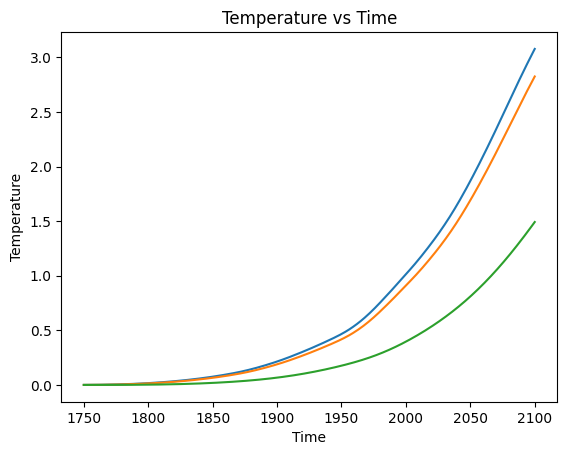

In [464]:
time_values = np.arange(start=1750, stop=2101)
temperature_values = np.array(f.temperature).reshape(351, 3)
plt.plot(time_values, temperature_values)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time')
plt.show()

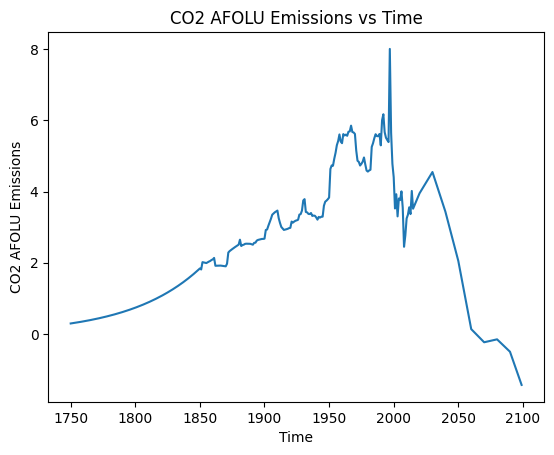

In [438]:
time_values = np.arange(start=1750, stop=2100)
co2_emissions = np.array(f.emissions.sel(specie="CO2 AFOLU")).reshape(350)
plt.plot(time_values, co2_emissions)
plt.xlabel('Time')
plt.ylabel('CO2 AFOLU Emissions')
plt.title('CO2 AFOLU Emissions vs Time')
plt.show()

In [449]:
np.array(f.emissions.sel(specie="CO2"), dtype=float).flatten()

array([  0.30697023,   0.31244306,   0.31802027,   0.32369631,
         0.32948047,   0.33537096,   0.34201646,   0.34812553,
         0.35434692,   0.36068269,   0.36713125,   0.37466298,
         0.38135469,   0.38816944,   0.39510948,   0.40217713,
         0.41065336,   0.4179833 ,   0.42544801,   0.43304998,
         0.44079172,   0.45002099,   0.45805008,   0.46622681,
         0.47455389,   0.48303408,   0.49308928,   0.50188422,
         0.51084088,   0.51996225,   0.52925505,   0.54051468,
         0.55014858,   0.55996334,   0.56995482,   0.58013771,
         0.59279864,   0.60335523,   0.6141022 ,   0.6250505 ,
         0.63620008,   0.64980889,   0.66201897,   0.67381004,
         0.68574822,   0.69796617,   0.71149677,   0.7253139 ,
         0.73922385,   0.75371674,   0.76888294,   0.78227564,
         0.80465962,   0.81382368,   0.83114241,   0.84500388,
         0.86151281,   0.87920763,   0.89216634,   0.90795154,
         0.92626321,   0.9448086 ,   0.96284398,   0.97

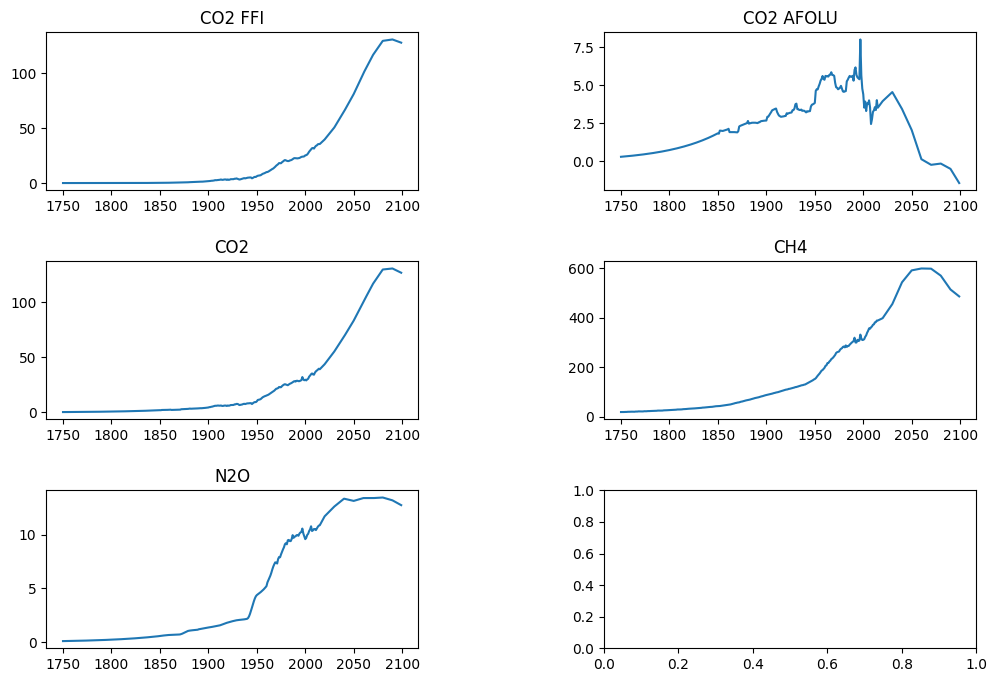

In [456]:
m, n = 3, 2
fig, axs = plt.subplots(m, n, figsize=(12,8))
for i in range(m):
    for j in range(n):
        index = i*n + j
        if (index >= 5): break
        ax = axs[i][j]
        ax.set_title(species[index])
        ax.plot(time_values, np.array(f.emissions.sel(specie=species[index]), dtype=float).flatten())

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.show()

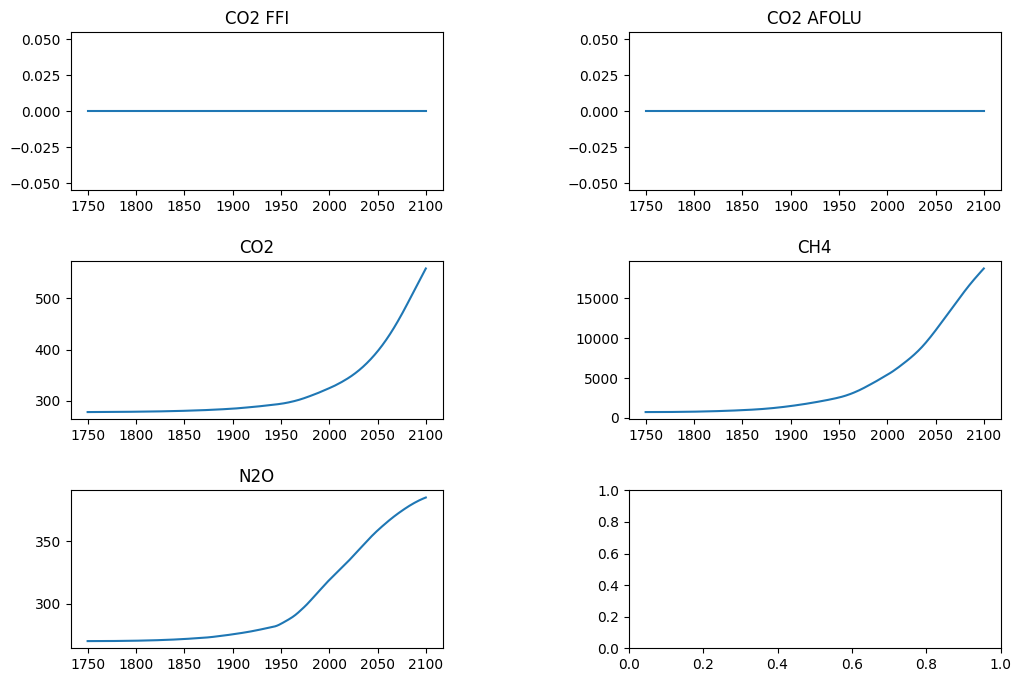

In [460]:
time_values = np.arange(start=1750, stop=2101)
m, n = 3, 2
fig, axs = plt.subplots(m, n, figsize=(12,8))
for i in range(m):
    for j in range(n):
        index = i*n + j
        if (index >= 5): break
        ax = axs[i][j]
        ax.set_title(species[index])
        ax.plot(time_values, np.array(f.concentration.sel(specie=species[index]), dtype=float).flatten())

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.show()

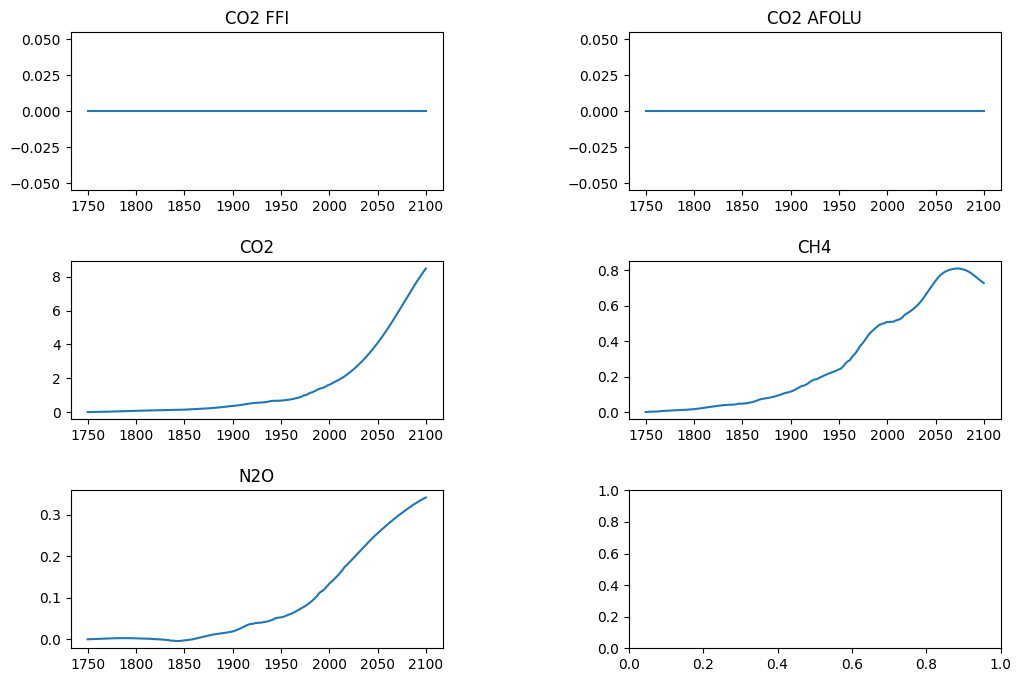

In [461]:
m, n = 3, 2
fig, axs = plt.subplots(m, n, figsize=(12,8))
for i in range(m):
    for j in range(n):
        index = i*n + j
        if (index >= 5): break
        ax = axs[i][j]
        ax.set_title(species[index])
        ax.plot(time_values, np.array(f.forcing.sel(specie=species[index]), dtype=float).flatten())

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.show()

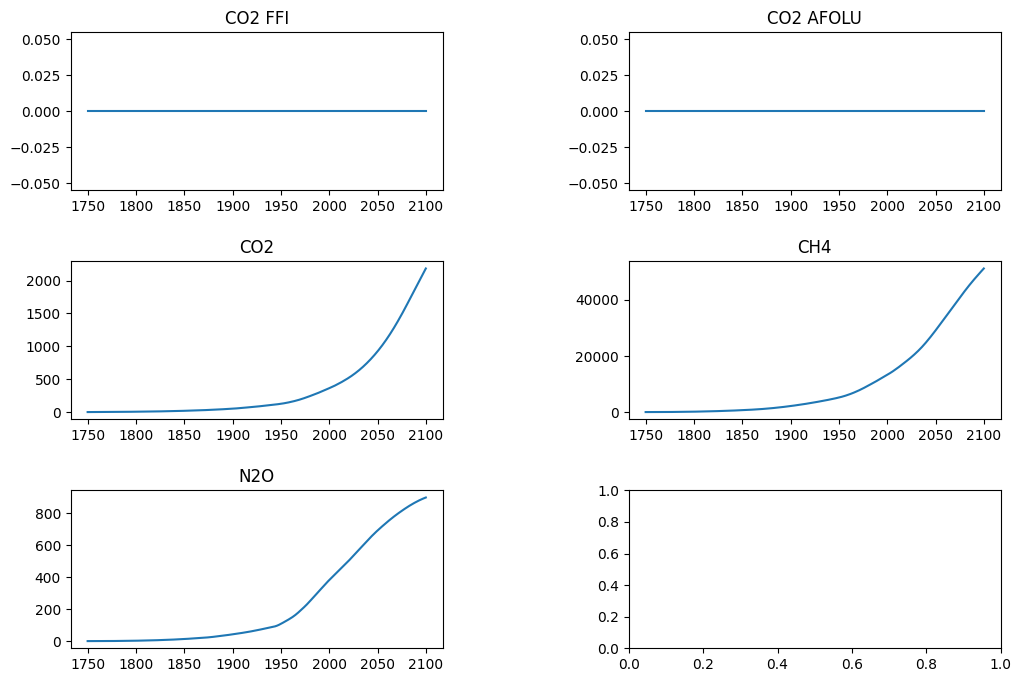

In [462]:
m, n = 3, 2
fig, axs = plt.subplots(m, n, figsize=(12,8))
for i in range(m):
    for j in range(n):
        index = i*n + j
        if (index >= 5): break
        ax = axs[i][j]
        ax.set_title(species[index])
        ax.plot(time_values, np.array(f.airborne_emissions.sel(specie=species[index]), dtype=float).flatten())

plt.subplots_adjust(wspace=0.5, hspace=0.45)
plt.show()

In [419]:
ebm3 = EnergyBalanceModel(
    ocean_heat_capacity=[1/1.876, 1.876, 5.154, 0.6435],
    ocean_heat_transfer=[1/2.632, 2.632, 9.262, 52.93],
    deep_ocean_efficacy=1.285,
    gamma_autocorrelation=28.24,
    sigma_xi=0.4395,
    sigma_eta=2.691,
    forcing_4co2=8,
    stochastic_run=False
)

In [420]:
epsilon_array = [1, ebm3.deep_ocean_efficacy, 1]

eb_matrix = [
    [-ebm3.gamma_autocorrelation, 0, 0, 0],
    [1/ebm3.ocean_heat_capacity[0], -(ebm3.ocean_heat_transfer[0] + epsilon_array[0] * ebm3.ocean_heat_transfer[1])/ebm3.ocean_heat_capacity[0], epsilon_array[0]*ebm3.ocean_heat_transfer[1]/ebm3.ocean_heat_capacity[0], 0],
    [0, ebm3.ocean_heat_transfer[1]/ebm3.ocean_heat_capacity[1], -(ebm3.ocean_heat_transfer[1] + epsilon_array[1] * ebm3.ocean_heat_transfer[2]) /
      ebm3.ocean_heat_capacity[1], epsilon_array[1] * ebm3.ocean_heat_transfer[2] / ebm3.ocean_heat_capacity[1]],
    [0, 0, ebm3.ocean_heat_transfer[2] / ebm3.ocean_heat_capacity[2], -(ebm3.ocean_heat_transfer[1]/ebm3.ocean_heat_capacity[1])]
]

ebm3.eb_matrix_d, np.exp(eb_matrix)

(array([[5.43905977e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00],
        [3.78679755e-03, 5.53208594e-02, 1.93870458e-01, 5.06805069e-01,
         8.12273764e-02],
        [3.69401415e-03, 5.50865999e-02, 2.12692748e-01, 5.87972568e-01,
         9.43425045e-02],
        [3.46985992e-03, 5.24159790e-02, 2.14015626e-01, 6.09871087e-01,
         9.79135791e-02],
        [3.46536753e-03, 5.23622034e-02, 2.14036853e-01, 6.10289168e-01,
         9.79817922e-02]]),
 array([[5.43905977e-13, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [6.52734320e+00, 3.51611723e-03, 1.39439665e+02, 1.00000000e+00],
        [1.00000000e+00, 4.06732313e+00, 4.31968085e-04, 5.69166935e+02],
        [1.00000000e+00, 1.00000000e+00, 6.03183233e+00, 2.45861951e-01]]))

In [421]:
# read through forcing file and fill forcing matrix
df_f = pd.read_csv('rcmip-radiative-forcing-annual-means-v5-1-0.csv')
df_f = df_f[(df_f['Scenario'].isin(scenarios)) & (df_f['Region'] == 'World')]

# rename variable field to match our current species names
for new_str, old_str in replacements.items():
    df_f['Variable'] = df_f['Variable'].str.replace(old_str, new_str)

# only match rows that match one of the specified species
df_f = df_f[(df_f['Variable'].str.endswith(tuple(species)))]

# Fill blank entries in the rcmip file with interpolated values
df1 = df_f.select_dtypes(exclude=[np.number])
df2 = df_f.select_dtypes([np.number])
df2 = df2.interpolate(method='linear', axis=1)
df_f = pd.concat([df1, df2], axis=1)

df_f.reset_index(drop=True, inplace=True)

for index, row in df_f.iterrows():
    last = row['Variable'].split('|')[-1]
    if (last in species):
        species_index = f.forcing.specie.values.tolist().index(last)
        f.forcing.loc[:, :, :, last] = np.array(df2.iloc[index][:351]).reshape(351, 1, 1)

f.forcing = f.forcing.fillna(0)
forcings = np.array(f.forcing.transpose().values).reshape(5, 351)
forcings = np.sum(forcings, axis=0)

ebm3.add_forcing(forcings, timestep=1)
forcings

array([0.00000000e+00, 1.19546168e-03, 2.80246098e-03, 4.10528740e-03,
       5.43329179e-03, 6.83287724e-03, 8.12295277e-03, 9.54217328e-03,
       1.07953435e-02, 1.18724981e-02, 1.28837207e-02, 1.43412313e-02,
       1.61404241e-02, 1.81531761e-02, 2.01257105e-02, 2.18721333e-02,
       2.33732786e-02, 2.52350022e-02, 2.68377350e-02, 2.83803396e-02,
       3.00008117e-02, 3.19410489e-02, 3.40028371e-02, 3.60212776e-02,
       3.77972838e-02, 4.00508069e-02, 4.24670698e-02, 4.47574268e-02,
       4.66448730e-02, 4.86371017e-02, 5.07704322e-02, 5.29483376e-02,
       5.52550882e-02, 5.74140386e-02, 5.95006118e-02, 6.16697528e-02,
       6.38212102e-02, 6.58856764e-02, 6.82206694e-02, 7.05580189e-02,
       7.29469891e-02, 7.53450474e-02, 7.76891303e-02, 7.96994064e-02,
       8.16670526e-02, 8.35062977e-02, 8.51251461e-02, 8.68877233e-02,
       8.85348362e-02, 9.04121873e-02, 9.24514341e-02, 9.45977010e-02,
       9.66277410e-02, 9.87543027e-02, 1.00995669e-01, 1.03153949e-01,
      

In [422]:
ebm3.emergent_parameters()
ebm3.ecs, ebm3.tcr

(10.527999999999487, 7.404641769526639)

In [423]:
ebm3.run()

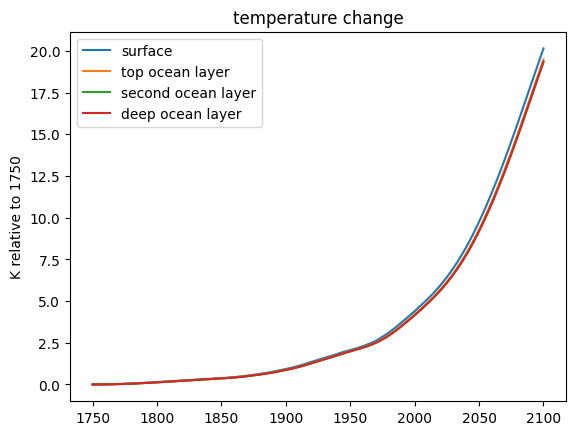

In [424]:
time = np.arange(1750, 2101)
plt.plot(time, ebm3.temperature[:,0], label='surface')
plt.plot(time, ebm3.temperature[:,1], label='top ocean layer')
plt.plot(time, ebm3.temperature[:,2], label='second ocean layer')
plt.plot(time, ebm3.temperature[:,3], label='deep ocean layer')
plt.ylabel('K relative to 1750')
plt.title('temperature change')
plt.legend()